# INTENT CLASSIFICATION USING ROBERTA
### https://huggingface.co/transformers/model_doc/roberta.html
### by/ AHMED ESSAM Abd Elgwad
### [https://www.linkedin.com/in/ahmed-essam-045161204/](https://www.linkedin.com/in/ahmedessamabdelatif/)

## Importing the libraries

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers.modeling_utils import PreTrainedModel
import torch
from torch.utils.data import Dataset

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from transformers import (
    RobertaTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    PreTrainedModel  
)



d:\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading the jason file (data)

In [2]:



# Step 1: Load and Preprocess JSON Data
def load_and_preprocess_data(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    rows = []
    for intent in data['intents']:
        texts = intent['text']  # List of text inputs
        for text in texts:
            rows.append({
                'Intent': intent['intent'],
                'Text': text
            })
    
    df = pd.DataFrame(rows)
    
    intent_labels = df['Intent'].unique()
    label2id = {label: idx for idx, label in enumerate(intent_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    df['Label'] = df['Intent'].map(label2id)
    
    return df, label2id, id2label


In [3]:
# Load Data and Split into Train/Test
json_file_path = 'D:/archive/Intent.json'  
df, label2id, id2label = load_and_preprocess_data(json_file_path)


## EDA on the intent and text features 

In [4]:
df.shape

(143, 3)

In [5]:


# Clean Text for Analysis
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# EDA Functions
def intent_distribution(df):
    intent_counts = df['Intent'].value_counts()
    print("Intent Distribution:")
    print(intent_counts)
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')
    plt.title('Distribution of Intents')
    plt.xlabel('Intent')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [6]:
def most_frequent_words(df, top_n=10):
    all_tokens = []
    for text in df['Text']:
        tokens = clean_text(text)
        all_tokens.extend(tokens)
    
    word_freq = Counter(all_tokens)
    common_words = word_freq.most_common(top_n)
    print(f"Top {top_n} Most Frequent Words:")
    for word, freq in common_words:
        print(f"{word}: {freq}")
    
    # Plot bar chart for frequent words
    words, freqs = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette='magma')
    plt.title(f'Top {top_n} Most Frequent Words in Text')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [7]:

def word_cloud(df):
    # Combine all text into one string
    all_text = ' '.join(df['Text'].apply(lambda x: ' '.join(clean_text(x))))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          max_words=100, min_font_size=10).generate(all_text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Text Column')
    plt.show()


In [8]:

def text_length_distribution(df):
    # Compute length of each text (in words)
    df['Text_Length'] = df['Text'].apply(lambda x: len(word_tokenize(x)))
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Text_Length'], bins=20, kde=True, color='blue')
    plt.title('Distribution of Text Lengths (in Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()



In [9]:
def bigram_frequency(df, top_n=10):
    # Generate bigrams (2-word pairs)
    all_bigrams = []
    for text in df['Text']:
        tokens = clean_text(text)
        bigrams = list(nltk.bigrams(tokens))
        all_bigrams.extend(bigrams)
    
    # Count bigram frequencies
    bigram_freq = Counter(all_bigrams)
    common_bigrams = bigram_freq.most_common(top_n)
    print(f"Top {top_n} Most Frequent Bigrams:")
    for bigram, freq in common_bigrams:
        print(f"{' '.join(bigram)}: {freq}")
    
    # Plot bar chart for bigrams
    bigrams, freqs = zip(*common_bigrams)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=bigram_labels, y=list(freqs), palette='coolwarm')
    plt.title(f'Top {top_n} Most Frequent Bigrams in Text')
    plt.xlabel('Bigrams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



=== NLP EDA ===
Intent Distribution:
Intent
GreetingResponse            8
CourtesyGreetingResponse    8
Greeting                    7
CourtesyGreeting            7
CurrentHumanQuery           7
RealNameQuery               7
PodBayDoor                  7
TimeQuery                   7
NotTalking2U                7
Shutup                      7
SelfAware                   7
PodBayDoorResponse          7
Clever                      7
NameQuery                   6
Gossip                      6
WhoAmI                      6
UnderstandQuery             6
Thanks                      6
CourtesyGoodBye             6
Jokes                       6
GoodBye                     4
Swearing                    4
Name: count, dtype: int64


C:\Users\acer\AppData\Local\Temp\ipykernel_19804\219667590.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')


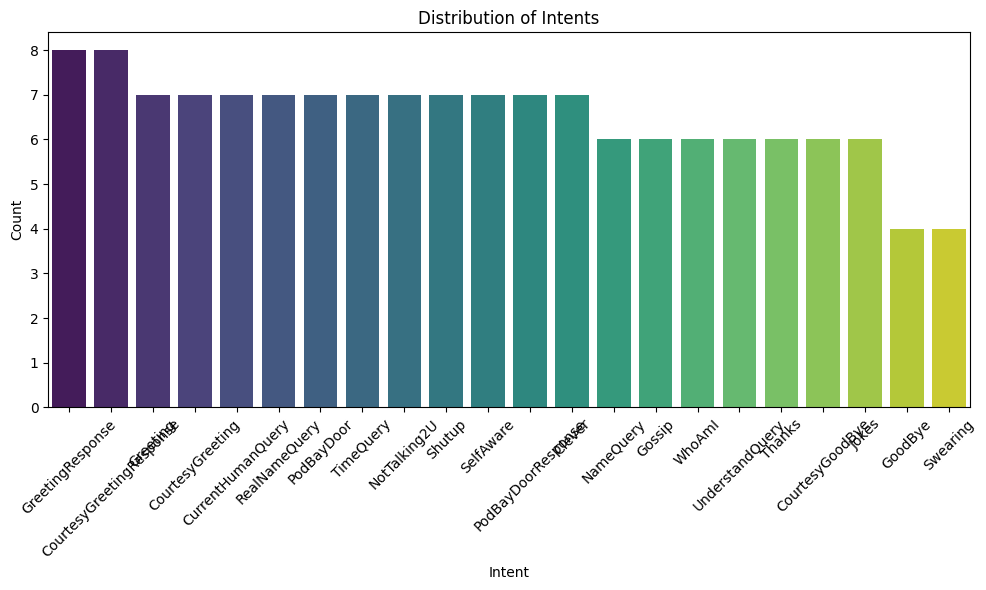

In [10]:
        # Perform EDA
print("=== NLP EDA ===")

intent_distribution(df)          # Intent distribution and bar plot


=== NLP EDA ===
Top 10 Most Frequent Words:
thanks: 14
name: 12
please: 11
tell: 9
pod: 9
bay: 9
door: 9
adam: 8
bella: 8
open: 8


C:\Users\acer\AppData\Local\Temp\ipykernel_19804\1633622546.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='magma')


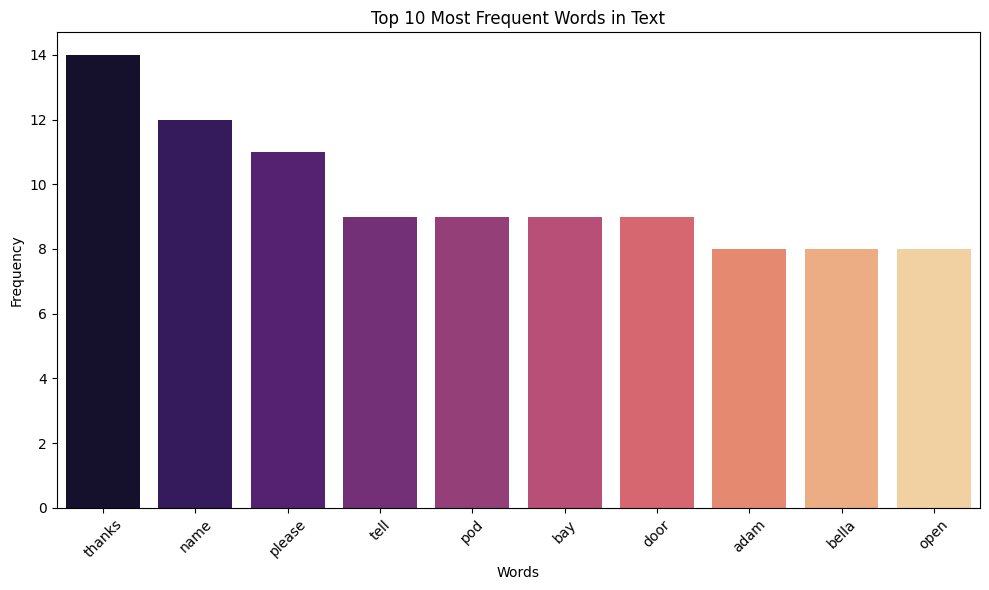

In [11]:
    # Perform EDA
print("=== NLP EDA ===")

most_frequent_words(df, top_n=10)  # Most frequent words and bar plot


=== NLP EDA ===


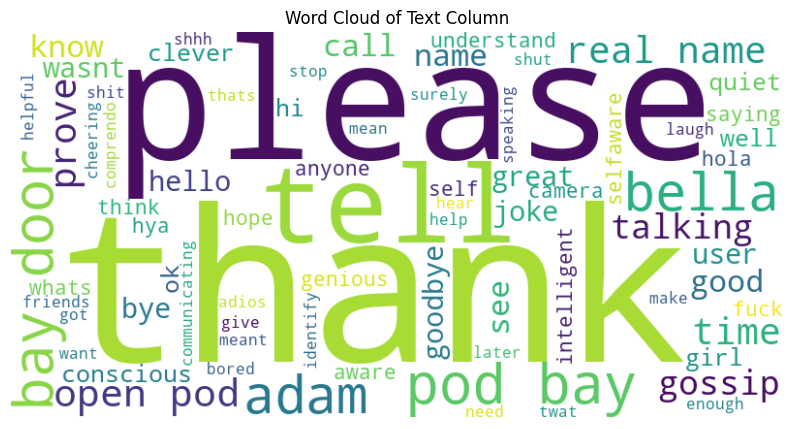

In [12]:
print("=== NLP EDA ===")
    
word_cloud(df)                   # Word cloud


=== NLP EDA ===


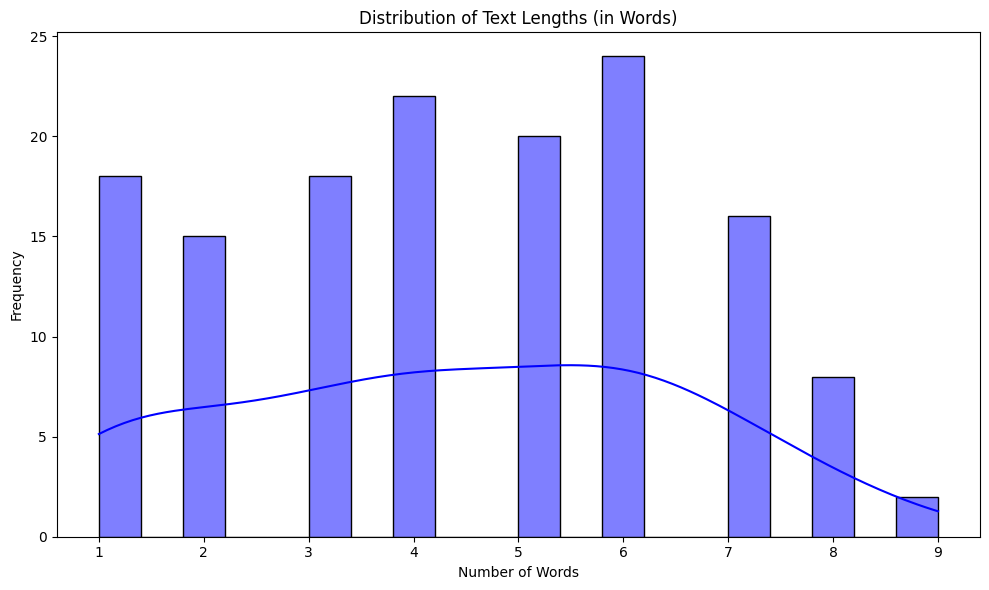

In [13]:
print("=== NLP EDA ===")
    
text_length_distribution(df)     # Text length distribution


=== NLP EDA ===
Top 10 Most Frequent Bigrams:
pod bay: 9
bay door: 9
open pod: 8
real name: 7
good thanks: 4
great thanks: 4
thanks adam: 3
thanks bella: 3
name please: 3
door please: 3


C:\Users\acer\AppData\Local\Temp\ipykernel_19804\3645976099.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_labels, y=list(freqs), palette='coolwarm')


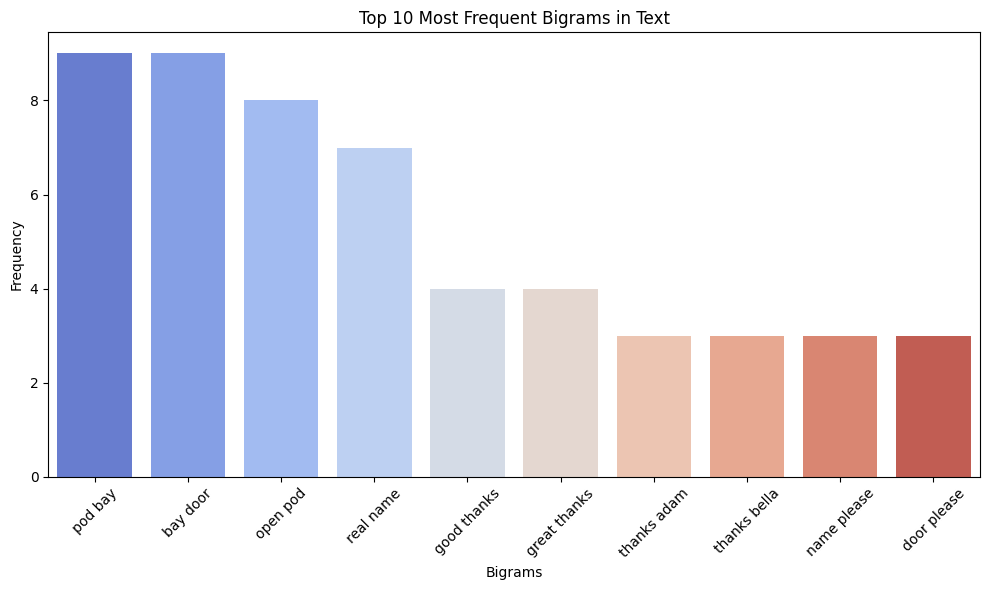

In [14]:
print("=== NLP EDA ===")
    
bigram_frequency(df, top_n=10)   # Bigram frequency and bar plot

## Initialize the model 

In [15]:

print("Trainer is working.")


class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


Trainer is working.


In [16]:


# Split into training and testing sets (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])



In [17]:



# Reset indices
train_texts, train_labels = train_df['Text'].values, train_df['Label'].values
test_texts, test_labels = test_df['Text'].values, test_df['Label'].values

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Create Datasets
train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
test_dataset = IntentDataset(test_texts, test_labels, tokenizer)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
id2label

{0: 'Greeting',
 1: 'GreetingResponse',
 2: 'CourtesyGreeting',
 3: 'CourtesyGreetingResponse',
 4: 'CurrentHumanQuery',
 5: 'NameQuery',
 6: 'RealNameQuery',
 7: 'TimeQuery',
 8: 'Thanks',
 9: 'NotTalking2U',
 10: 'UnderstandQuery',
 11: 'Shutup',
 12: 'Swearing',
 13: 'GoodBye',
 14: 'CourtesyGoodBye',
 15: 'WhoAmI',
 16: 'Clever',
 17: 'Gossip',
 18: 'Jokes',
 19: 'PodBayDoor',
 20: 'PodBayDoorResponse',
 21: 'SelfAware'}

In [19]:
label2id

{'Greeting': 0,
 'GreetingResponse': 1,
 'CourtesyGreeting': 2,
 'CourtesyGreetingResponse': 3,
 'CurrentHumanQuery': 4,
 'NameQuery': 5,
 'RealNameQuery': 6,
 'TimeQuery': 7,
 'Thanks': 8,
 'NotTalking2U': 9,
 'UnderstandQuery': 10,
 'Shutup': 11,
 'Swearing': 12,
 'GoodBye': 13,
 'CourtesyGoodBye': 14,
 'WhoAmI': 15,
 'Clever': 16,
 'Gossip': 17,
 'Jokes': 18,
 'PodBayDoor': 19,
 'PodBayDoorResponse': 20,
 'SelfAware': 21}

## Training the model

In [20]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=100,              # Number of epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps
    eval_strategy='epoch',     # Evaluate at the end of each epoch
    save_strategy='epoch',           # Save model at the end of each epoch
    load_best_model_at_end=True,     # Load the best model based on metric
    metric_for_best_model='accuracy' # Metric to optimize
)

# Define Compute Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, target_names=label2id.keys(), output_dict=True)
    return {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the Model
print("Starting training...")
trainer.train()
print("Training completed.")

# Evaluate the Model
print("Evaluating model...")
eval_results = trainer.evaluate()
print("Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Save the Model and Tokenizer
model.save_pretrained('./intent_classifier_model')
tokenizer.save_pretrained('./intent_classifier_model')
print("Model and tokenizer saved to './intent_classifier_model'")



Starting training...


d:\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.130200,3.103407,0.034483,0.001189,0.034483,0.002299
2,3.114500,3.101840,0.034483,0.001189,0.034483,0.002299
3,3.083100,3.099620,0.034483,0.001189,0.034483,0.002299
4,3.098000,3.093385,0.034483,0.001189,0.034483,0.002299
5,3.090200,3.076644,0.034483,0.001189,0.034483,0.002299
6,3.035500,2.972167,0.103448,0.087533,0.103448,0.071520
7,2.913200,2.715703,0.482759,0.340230,0.482759,0.379310
8,2.540400,2.436759,0.586207,0.531609,0.586207,0.534483
9,2.295500,2.128106,0.689655,0.603448,0.689655,0.621839
10,1.865700,1.840650,0.724138,0.695402,0.724138,0.685057


d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' arg

Training completed.
Evaluating model...


d:\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation results:
eval_loss: 0.5271
eval_accuracy: 0.8966
eval_precision: 0.8908
eval_recall: 0.8966
eval_f1: 0.8793
eval_runtime: 3.8176
eval_samples_per_second: 7.5960
eval_steps_per_second: 1.0480
epoch: 100.0000
Model and tokenizer saved to './intent_classifier_model'


## Testing the model

In [21]:
# Make Predictions
def predict_intent(text, model, tokenizer, id2label, max_length=128):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    with torch.no_grad():
        outputs = model(
            input_ids=encoding['input_ids'],
            attention_mask=encoding['attention_mask']
        )
        logits = outputs.logits
        predicted_id = torch.argmax(logits, dim=1).item()
    
    return id2label[predicted_id]



In [22]:
# Example prediction
sample_text = "Hello there"
predicted_intent = predict_intent(sample_text, model, tokenizer, id2label)
print(f"Sample text: '{sample_text}'")
print(f"Predicted intent: {predicted_intent}")

Sample text: 'Hello there'
Predicted intent: Greeting


In [23]:
# Example prediction
sample_text = "That's helpful"
predicted_intent = predict_intent(sample_text, model, tokenizer, id2label)
print(f"Sample text: '{sample_text}'")
print(f"Predicted intent: {predicted_intent}")

Sample text: 'That's helpful'
Predicted intent: Thanks
